# Anomaly Detection

> In this example we show how to detect anomalies for time series using insample prediction intervals.

<a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/examples/UncertaintyIntervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing StatsForecast Library

In [ ]:
!pip install statsforecast neuralforecast

In [ ]:
import random
import warnings
warnings.filterwarnings("ignore")
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

#### Useful functions

The `plot_grid` function defined below will be useful to plot different time series, and different models' forecasts.

In [ ]:
def plot_grid(df_train, df_test=None, plot_random=True, level=None, anomalies=False):
    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"
    
    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'y_train')
        if level is not None and anomalies: 
            axes[idx, idy].fill_between(
                train_uid['ds'], 
                train_uid[f'AutoARIMA-lo-{level}'], 
                train_uid[f'AutoARIMA-hi-{level}'],
                alpha=0.9,
                color='orange',
                label=f'AutoARIMA_level_{level}',
            )
            filt = (train_uid['y'] > train_uid[f'AutoARIMA-hi-{level}']) | (train_uid[f'AutoARIMA-lo-{level}'] > train_uid['y'])
            anomalies_df = train_uid[filt][['ds', 'y']]
            axes[idx, idy].scatter(
                anomalies_df['ds'],
                anomalies_df['y'],
                color='red',
                label='Anomalies'
            )
        if df_test is not None:
            max_ds = train_uid['ds'].max()
            test_uid = df_test.query('unique_id == @uid')
            models = df_test.drop(['unique_id', 'ds'], axis=1).columns
            for model in models:
                if all(np.isnan(test_uid[model])):
                    continue
                if 'lo' in model or 'hi' in model:
                    continue
                axes[idx, idy].plot(test_uid['ds'], test_uid[model], label=model)
            if level is not None:
                for l in level:
                    axes[idx, idy].fill_between(
                        test_uid['ds'], 
                        test_uid[f'AutoARIMA-lo-{l}'], 
                        test_uid[f'AutoARIMA-hi-{l}'],
                        alpha=1 - l // 100,
                        color='orange',
                        label=f'AutoARIMA_level_{l}',
                    )
        axes[idx, idy].set_title(f'M4 Hourly: {uid}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Target')
        axes[idx, idy].legend(loc='upper left')
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.5)
    plt.show()

## Download data

For testing purposes, we will use the Hourly dataset from the M4 competition.

In [ ]:
%%capture
!wget https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv

In [ ]:
train = pd.read_csv('M4-Hourly.csv')

In this example we will use a subset of the data to avoid waiting too long. You can modify the number of series if you want.

In [ ]:
n_series = 8
uids = train['unique_id'].unique()[:n_series]
train = train.query('unique_id in @uids')

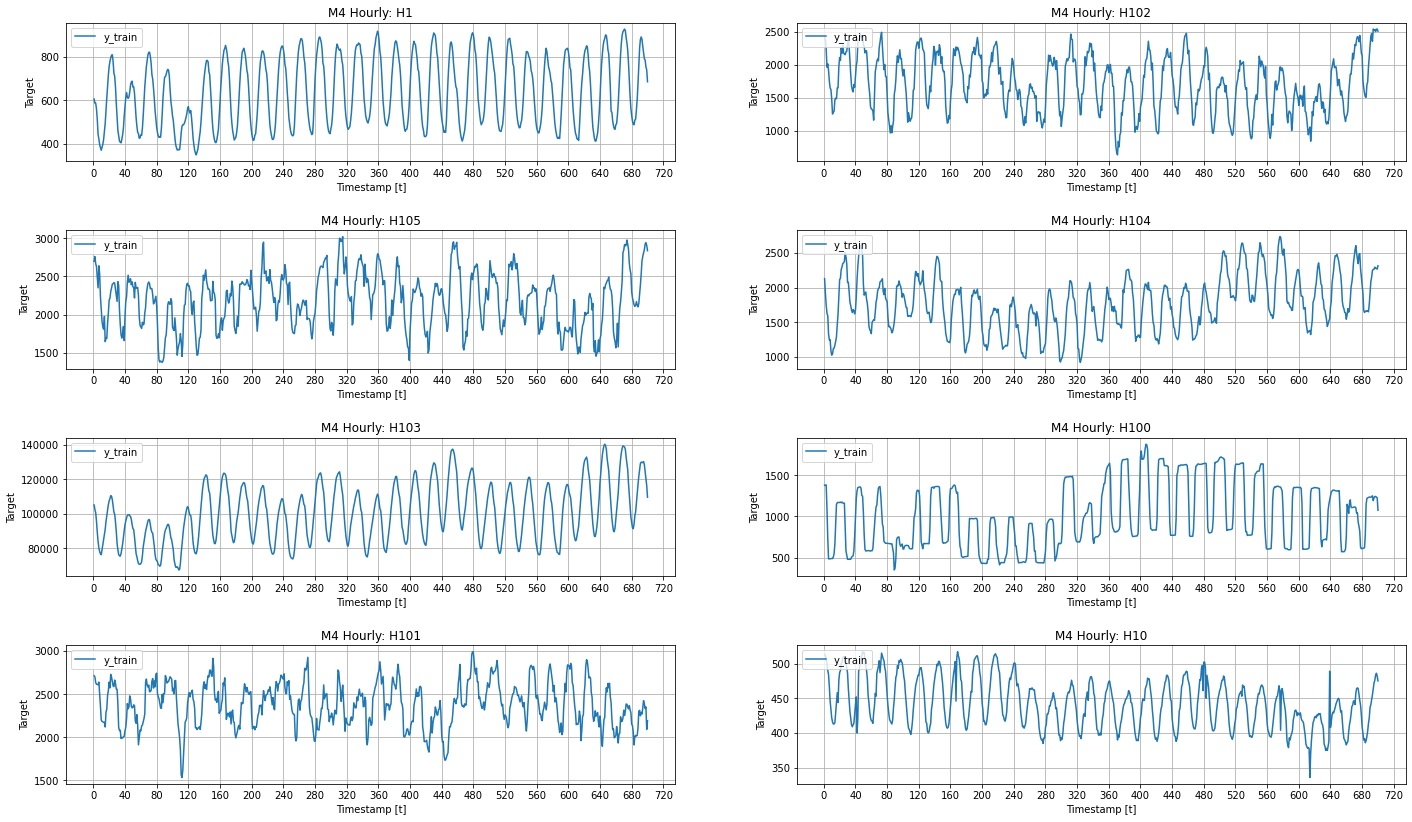

In [ ]:
plot_grid(train)

## Train the model

`StatsForecast` receives a list of models to fit each time series. Since we are dealing with Hourly data, it would be benefitial to use 24 as seasonality.

In [ ]:
models = [AutoARIMA(season_length=24, approximation=True)]

In [ ]:
fcst = StatsForecast(df=train, 
                     models=models, 
                     freq='H', 
                     n_jobs=-1)

We can define the level of the forecast intervals we want to produce. StatsForecast will produce these levels for both forecasts and intra-sample forecasts.

In [ ]:
levels = [80, 90, 95, 99]

Observe that we need to pass `fitted=True` to the `forecast` method to recover the insample forecasts.

In [ ]:
forecasts = fcst.forecast(h=48, fitted=True, level=levels)

In [ ]:
forecasts = forecasts.reset_index()

In [ ]:
forecasts.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-lo-95,AutoARIMA-lo-90,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-90,AutoARIMA-hi-95,AutoARIMA-hi-99
0,H1,701,616.084167,585.106445,592.513000,596.302612,600.671814,631.496460,635.865662,639.655273,647.061890
1,H1,702,544.432129,494.394348,506.358063,512.479370,519.536865,569.327393,576.384888,582.506165,594.469910
2,H1,703,510.414490,443.625366,459.594238,467.764801,477.184906,543.644043,553.064148,561.234741,577.203613
3,H1,704,481.046539,404.228729,422.595398,431.992798,442.827393,519.265686,530.100281,539.497681,557.864380
4,H1,705,460.893066,378.863678,398.476410,408.511383,420.081024,501.705109,513.274780,523.309692,542.922424


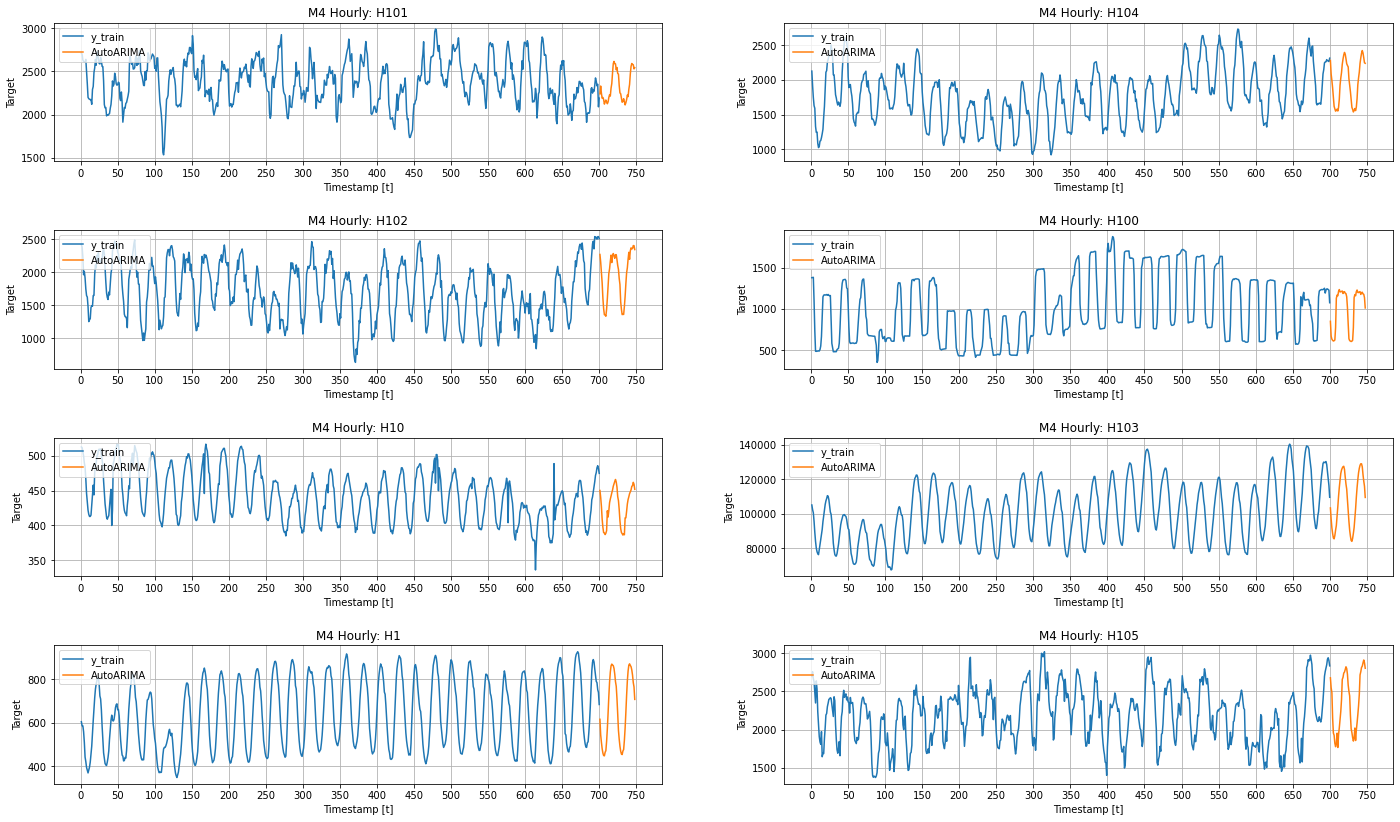

In [ ]:
plot_grid(train, forecasts)

## Recover insample forecasts

Once the model is fitted, we can recover the insample forecasts and their prediction intervals using `forecast_fitted_values`.

In [ ]:
insample_forecasts = fcst.forecast_fitted_values().reset_index()

In [ ]:
insample_forecasts.head()

,unique_id,ds,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-lo-95,AutoARIMA-lo-90,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-90,AutoARIMA-hi-95,AutoARIMA-hi-99
0,H1,1,605.0,604.395020,573.417297,580.823853,584.613464,588.982666,619.807312,624.176514,627.966125,635.372742
1,H1,2,586.0,585.414001,554.436279,561.842896,565.632507,570.001648,600.826355,605.195557,608.985168,616.391724
2,H1,3,586.0,585.414001,554.436279,561.842896,565.632507,570.001709,600.826355,605.195557,608.985168,616.391724
3,H1,4,559.0,558.441040,527.463318,534.869873,538.659485,543.028687,573.853333,578.222534,582.012146,589.418762
4,H1,5,511.0,510.489014,479.511292,486.917877,490.707520,495.076691,525.901367,530.270569,534.060181,541.466736


## Plot anomalies

In this example, we consider as an anomaly an observation that is above the upper prediction interval or below the lower prediction interval of a certain probability level.

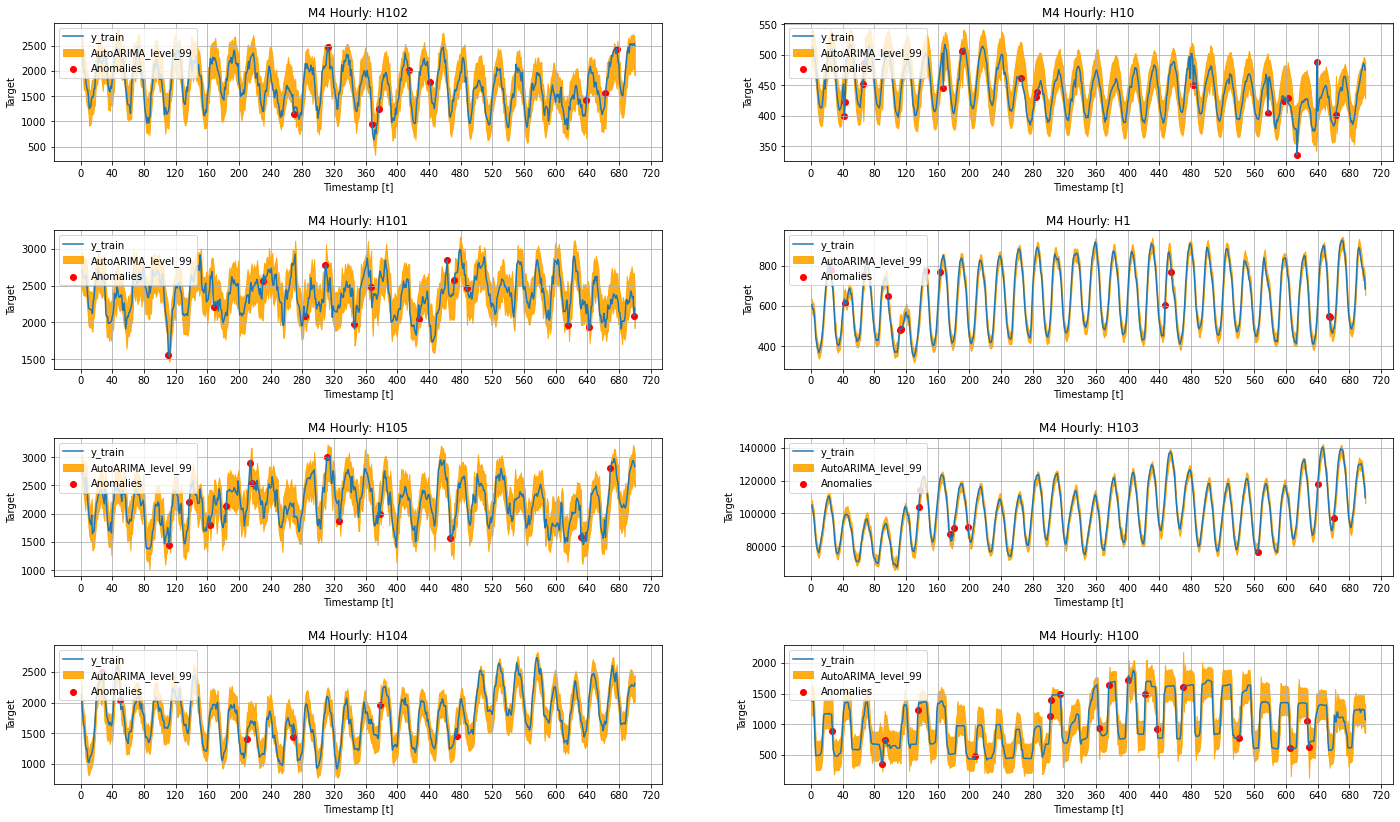

In [ ]:
plot_grid(insample_forecasts, level=99, anomalies=True)

We can also create a widget to change the probability level of the prediction intervals.

In [ ]:
@interact(level=reversed(levels))
def plot_anomalies(level):
    plot_grid(insample_forecasts, level=level, anomalies=True)

interactive(children=(Dropdown(description='level', options=(99, 95, 90, 80), value=99), Output()), _dom_class…

<a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/examples/UncertaintyIntervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>